# SSD - Sequência de dígitos MNIST

# Setup

## Importando os módulos

In [1]:
#!pip install matplotlib torch torchvision shapely[vectorized]

In [2]:
#!wget -q https://raw.githubusercontent.com/fabiocapsouza/ia376f/master/lib/pytorch_trainer_v2_mod.py -Plib/

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline
import os
import math
import warnings
from collections import OrderedDict

import cv2
import numpy as np
from shapely import geometry

import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import matplotlib.cm as cmx
import matplotlib.colors as mcolors

import torch
import torch.nn as nn
from torch.utils import data
from torch.optim import lr_scheduler
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# our library
from lib import pytorch_trainer_v2_mod as ptt

In [5]:
torch.backends.cudnn.benchmark = False

In [6]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)
print('CPU Cores:', os.cpu_count())
print('Versão OpenCV:', cv2.__version__)

Usando GPU: True
CPU Cores: 4
Versão OpenCV: 3.4.2


## Funções de plot
Funções do fast.ai para plotar imagens e boxes

In [7]:
def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [271]:
def show_img(im, figsize=None, ax=None, cmap='gray'):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, cmap=cmap)
    ax.set_xticks(np.linspace(0, 224, 14+1), minor=True)
    ax.set_xticks(np.linspace(0, 224, 7+1), minor=False)
    ax.set_yticks(np.linspace(0, 224, 14+1), minor=True)
    ax.set_yticks(np.linspace(0, 224, 7+1), minor=False)
    # ax.set_xticks(np.linspace(0, 224, 8))
    # ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid(True, which='major', linestyle='-', color='gray')
    ax.grid(True, which='minor', linestyle=':', color='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    """b: box (x0, y0, w, h)"""
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

## Funções úteis para conversão de listas/dicionários de tensores

In [9]:
def to_device(T, device):
    if isinstance(T, (list, tuple)):
        return [to_device(t, device) for t in T]
    elif isinstance(T, dict):
        return {k: to_device(t) for k, t in T.items()}
    return T.to(device)

def to_cpu(T):
    if isinstance(T, (list, tuple)):
        return tuple(t.cpu() for t in T)
    elif isinstance(T, dict):
        return {k: t.cpu() for k, t in T.items()}
    return T.cpu()

def to_np(T):
    T = to_cpu(T)
    if isinstance(T, (list, tuple)):
        return tuple(t.detach().numpy() for t in T)
    elif isinstance(T, dict):
        return {k: t.detach().numpy() for k, t in T.items()}
    return T.detach().numpy()

## Funções para conversão entre diferentes representações de bounding box

Nomenclaturas:

- xyhw: (x0, y0, w, h)
- corners: (x0, y0, x1, y1)
- centerhw: (cx, cy, w, h)

Funções:

- `hw2corners:       (cx, cy,  w,  h) -> (x0, y0, x1, y1)`
- `corners2xyhw:     (x0, y0, x1, y1) -> (x0, y0,  w,  h)`
- `corners2centerhw: (x0, y0, x1, y1) -> (cx, cy,  w,  h)`
- `hw2xy:            (x0, y0,  w,  h) -> (x0, y0, x1, y1)`

In [10]:
# Conversão entre representações de bboxes
def hw2corners(centers, wh):
    """ bbox centers+wh to top-left+bottom-right"""
    return torch.cat([centers - wh/2, centers + wh/2], dim=1)

def corners2xyhw(tleft, bright):
    """ bbox top-left+bottom-right to top-left+wh."""
    return torch.cat([tleft, bright-tleft], dim=1)

def corners2centerhw(topleft, botright):
    """ bbox x0,y0,x1,y1 to cx,cy,w,h."""
    centers = (topleft + botright)/2
    wh = (botright - topleft)
    return torch.cat([centers, wh], dim=1)

def hw2xy(box):
    """bbox top-left+wh to top-left+bottom-right"""
    return torch.cat([box[:,:2], box[:,:2] + box[:,2:]], dim=1)

# Definição do dataset com múltiplos dígitos

## Carregando MNIST dataset

In [11]:
!mkdir data/MNIST

mkdir: cannot create directory ‘data/MNIST’: File exists


In [15]:
dataset_dir = 'data/MNIST/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = transforms.ToTensor()
# data_transform = None

# carrega o conjunto de treinamento e de teste
datasets_mnist = dict(train=MNIST(dataset_dir, train=True,  transform=data_transform, download=True),
                val  =MNIST(dataset_dir, train=False, transform=data_transform, download=True))

print('Amostras para treinamento:', len(datasets_mnist['train']))
print('Amostras para validação:', len(datasets_mnist['val']))
print(type(datasets_mnist['train'].train_data))
print(datasets_mnist['train'].train_data.size())
print(datasets_mnist['train'].train_data.min(), datasets_mnist['train'].train_data.max())

Amostras para treinamento: 60000
Amostras para validação: 10000
<class 'torch.Tensor'>
torch.Size([60000, 28, 28])
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


## Funções para criação de amostras

In [27]:
def make_geometry_box(h, w, H, W):
    """
    h e w: altura e largura do dígito
    H e W: altura e largura da imagem
    """
    x = np.random.randint(0, W-1-w)
    y = np.random.randint(0, H-1-h)
    digit_box = geometry.box(x, y, x+w, y+h)
    return x, y, digit_box


def make_digit_sequence(dataset, digits_ixs, resizing_factor, spacing):
    """Takes a sequence of digits_ixs and concatenate the images from dataset laterally."""
    
    H = int(math.ceil(28 * resizing_factor))
    spacing = int(round(spacing * resizing_factor))
    W = H + (H - spacing) * (len(digits_ixs) - 1)
    seq_img = np.zeros((H, W), dtype=np.int)
    
    seq_label = []
    
    x = 0
    for j, ix in enumerate(digits_ixs):
        img, lab = dataset[ix]
        img, lab = img.numpy(), lab.numpy()
        img = img.reshape(28, 28)
        seq_label.append(str(int(lab)))
        
        img = cv2.resize(img, (H, H), #fx=resizing_factor, fy=resizing_factor,
                         interpolation=cv2.INTER_AREA if resizing_factor < 1 else cv2.INTER_LINEAR)
        img = (img * 255).clip(0, 255).astype(np.uint8)
        if j > 0:
            seq_img[:, x-spacing:x-spacing+H] += img
        else:
            seq_img[:, x:x+H] += img
        x += H-spacing
        
    seq_img = np.clip(seq_img, 0, 255).astype(np.uint8)
        
    return seq_img, ''.join(seq_label)


# Função para criar uma imagem de teste, colocando várias amostras
def make_sample(dataset, image_size, min_seq=6, max_seq=6, min_digits=1, max_digits=6, seed=None):
    """Creates an image with many digits from MNIST, without overlap.
    The parameters min_digits and max_digits control the density of digits
    in the samples.
    
    Parameters:
    -----------
    dataset: an instance of MNIST dataset.
    image_size: the output image size. Should be an int of tuple of ints.
    min_seq (int): minimum number of digit sequences in image.
    max_seq (int): maximum number of digit sequences in image.
    min_digits (int): minimum number of digits in a sequence.
    max_digits (int): maximum number of digits in a sequence.
    seed (int, optional): constrols the random seed used to generate the images.
        Used for controlling the randomness of the samples.  
    """
    if isinstance(image_size, int):
        M = (image_size, image_size)
    elif isinstance(image_size, (tuple, list)):
        M = image_size
    else:
        raise TypeError("`image_size` should be an int of tuple of ints.")
    H, W = M
    
    if seed is not None:
        np.random.seed(seed)
    
    Ns = np.random.randint(min_seq, max_seq)    # Number of digit sequences
    
    # Empty image and outputs
    boxes = []
    boxes_geo = []
    image = np.zeros(M, np.uint8)
    
    spacing = 3   # pixels that will be removed between consecutive digits in a sequence
    
    for seq_ix in range(Ns):
        
        # Samples a number of digits
        N_digits = np.random.randint(min_digits, max_digits)
        
        # Samples a resizing factor and a random position for the digit
        max_factor = min((0.95*H / N_digits) / 28, 2)
        resizing_factor = np.random.uniform(1, max_factor)
        
        hs = int(math.ceil(img.shape[0] * resizing_factor))
        res_spacing = int(round(spacing * resizing_factor))
        ws = hs + (hs - res_spacing) * (N_digits - 1)
        x, y, seq_box = make_geometry_box(hs, ws, H, W)

        if boxes:
            retries = 0
            skip = False
            # If the geometry box intersects with a previous box, resample
            while any(seq_box.intersects(box) for box in boxes_geo):
                if retries > 10:
                    skip = True
                    break
                x, y, seq_box = make_geometry_box(hs, ws, H, W)
                retries += 1
            if skip:
                continue
        
        boxes_geo.append(seq_box)
        digits_ixs = np.random.choice(len(dataset), N_digits, replace=False)
        seq_img, seq_label = make_digit_sequence(dataset, digits_ixs, resizing_factor, spacing)
        
        assert (hs, ws) == seq_img.shape
        
        boxes.append({
            'coords': np.array([x, y, x+ws, y+hs], dtype=np.float) / H,  # This assumes square image size
            'label': seq_label,
        })
        image[y:y+hs, x:x+ws] = seq_img
        
    return image, boxes

Text(0.5,1,'493922')

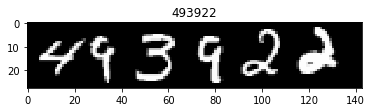

In [32]:
img, lab = make_digit_sequence(datasets_mnist['train'], np.random.randint(0, 60000, 6), 1, 5)
plt.imshow(img, cmap='gray')
plt.title(lab)

In [40]:
sample = make_sample(datasets_mnist['train'], (224, 224), min_seq=3, max_seq=6, seed=None)
sample

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 [{'coords': array([0.23214286, 0.60714286, 0.47767857, 0.73660714]),
   'label': '52'},
  {'coords': array([0.17410714, 0.19196429, 0.92857143, 0.35714286]),
   'label': '64309'},
  {'coords': array([0.54910714, 0.73660714, 0.72321429, 0.91071429]),
   'label': '2'},
  {'coords': array([0.3125    , 0.80357143, 0.47321429, 0.96428571]),
   'label': '6'}])

In [41]:
def plot_sample(sample):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

    img, targets = sample
    H, W = img.shape
    img = np.dstack((img, img, img))
    
    boxes = [box['coords'] for box in targets]
    clss = [box['label'] for box in targets]
    
    show_img(img, ax=ax)
    for i, (box, cls) in enumerate(zip(boxes, clss)):
        b = np.concatenate([box[:2], box[2:] - box[:2]])
        b[::2] *= W
        b[1::2] *= H
        clr = colr_list[i % len(colr_list)]
        draw_rect(ax, b, color=clr)
        draw_text(ax, b[:2], str(cls), color=clr)

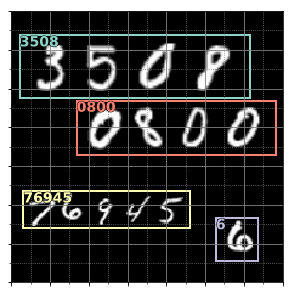

In [272]:
plot_sample(make_sample(datasets_mnist['train'], (224, 224), min_seq=3, max_seq=6, seed=42))

## Classe Dataset para sequência de dígitos


In [48]:
class MultiSequenceDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset, image_size=(224, 224), transform=None, length=None,
                 random=False, min_seq=3, max_seq=6):
        """
        Parameters:
        -----------
        dataset (Dataset): an MNIST dataset to be used for sampling digits.
        image_size (int, Tuple(int)): image size.
        transform: transform to be applied to the image only (not targets).
        length (int, optional): defines the number of samples of the dataset.
            If `None`, it is equal to the length of `dataset`.
        random (bool, default: False): controls the randomness of the samples.
            If False, the index given in __getitem__ is used as the seed to generate
            always the same images. If True, it generates a new sample in every execution.
        """
        self.dataset = dataset
        self.image_size = image_size
        self.length = length or len(dataset)
        self.random = random
        self.min_seq = min_seq
        self.max_seq = max_seq
        
        self.transform = transform
        
    def set_length(self, length):
        """Sets the length of the dataset. Useful to limit the dataset
        to a small number of samples."""
        self.length = length
        
    def __len__(self):
        return self.length
        
    def __getitem__(self, ix):
        seed = ix if not self.random else None
        img, boxes = make_sample(self.dataset, self.image_size, 
                                 min_seq=self.min_seq, max_seq=self.max_seq,
                                 seed=seed)
        
        img = img[..., np.newaxis]
        
        if self.transform:
            img = self.transform(img)
        return img, boxes

Visualizando shapes, dtypes, valores mínimo e máximo

In [49]:
ds = {
    'train': MultiSequenceDataset(datasets_mnist['train'],
                                  image_size=(224, 224),
                                  length=128,
                                  random=False,
                                  transform=transforms.ToTensor()),
    'val': MultiSequenceDataset(datasets_mnist['val'],
                                image_size=(224, 224),
                                length=128,
                                random=False,
                                transform=transforms.ToTensor()),
}

In [51]:
x, y = ds['train'][0]

print('x:', x.shape, x.dtype, x.min(), x.max())
print(y)

x: torch.Size([1, 224, 224]) torch.float32 tensor(0.) tensor(0.9961)
[{'coords': array([0.45982143, 0.04017857, 0.66071429, 0.24107143]), 'label': '3'}, {'coords': array([0.38839286, 0.4375    , 0.8125    , 0.66071429]), 'label': '84'}]


# Definição do modelo

## Construindo as âncoras:

- Anchors 37x37 para camada de downsample 16 com 3 razões de aspecto
- Anchors 46x46 para camada de  downsample 32 com 3 razões de aspecto

In [269]:
def make_anchors(anc_grid, anc_size, k=1):
    """
    Constrói anchors de acordo com os tamanhos fornecidos para
    o grid e para as anchors.
    
    anc_grid (int): dimension (h|w) of the feature map.
    anc_size (float or tuple of floats): size (WH) of the anchors, relative to the image size.
    Retorna anchors (Cx, Cy, H, W) com shape (k*anc_grid*anc_grid, 4).
    """
    if isinstance(anc_size, float):
        anc_size = (anc_size, anc_size)
    
    anc_offset = 1/(anc_grid*2)
    anc_x = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
    anc_y = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

    anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
    anc_sizes = np.array([anc_size for i in range(anc_grid*anc_grid)])
    anchors = torch.tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
    return anchors

In [273]:
# Anchor para a camada com downsample 16 => grid 14x14
# Exemplo: Razão de aspecto w:h = 3:1
make_anchors(14, (37*3/224, 37/224))

tensor([[0.0357, 0.0357, 0.4955, 0.1652],
        [0.1071, 0.0357, 0.4955, 0.1652],
        [0.1786, 0.0357, 0.4955, 0.1652],
        [0.2500, 0.0357, 0.4955, 0.1652],
        [0.3214, 0.0357, 0.4955, 0.1652],
        [0.3929, 0.0357, 0.4955, 0.1652],
        [0.4643, 0.0357, 0.4955, 0.1652],
        [0.5357, 0.0357, 0.4955, 0.1652],
        [0.6071, 0.0357, 0.4955, 0.1652],
        [0.6786, 0.0357, 0.4955, 0.1652],
        [0.7500, 0.0357, 0.4955, 0.1652],
        [0.8214, 0.0357, 0.4955, 0.1652],
        [0.8929, 0.0357, 0.4955, 0.1652],
        [0.9643, 0.0357, 0.4955, 0.1652],
        [0.0357, 0.1071, 0.4955, 0.1652],
        [0.1071, 0.1071, 0.4955, 0.1652],
        [0.1786, 0.1071, 0.4955, 0.1652],
        [0.2500, 0.1071, 0.4955, 0.1652],
        [0.3214, 0.1071, 0.4955, 0.1652],
        [0.3929, 0.1071, 0.4955, 0.1652],
        [0.4643, 0.1071, 0.4955, 0.1652],
        [0.5357, 0.1071, 0.4955, 0.1652],
        [0.6071, 0.1071, 0.4955, 0.1652],
        [0.6786, 0.1071, 0.4955, 0

In [274]:
# Anchors com downsample=32 => grid 7x7 => grid_size=7
make_anchors(7, 46/224)

tensor([[0.0714, 0.0714, 0.2054, 0.2054],
        [0.2143, 0.0714, 0.2054, 0.2054],
        [0.3571, 0.0714, 0.2054, 0.2054],
        [0.5000, 0.0714, 0.2054, 0.2054],
        [0.6429, 0.0714, 0.2054, 0.2054],
        [0.7857, 0.0714, 0.2054, 0.2054],
        [0.9286, 0.0714, 0.2054, 0.2054],
        [0.0714, 0.2143, 0.2054, 0.2054],
        [0.2143, 0.2143, 0.2054, 0.2054],
        [0.3571, 0.2143, 0.2054, 0.2054],
        [0.5000, 0.2143, 0.2054, 0.2054],
        [0.6429, 0.2143, 0.2054, 0.2054],
        [0.7857, 0.2143, 0.2054, 0.2054],
        [0.9286, 0.2143, 0.2054, 0.2054],
        [0.0714, 0.3571, 0.2054, 0.2054],
        [0.2143, 0.3571, 0.2054, 0.2054],
        [0.3571, 0.3571, 0.2054, 0.2054],
        [0.5000, 0.3571, 0.2054, 0.2054],
        [0.6429, 0.3571, 0.2054, 0.2054],
        [0.7857, 0.3571, 0.2054, 0.2054],
        [0.9286, 0.3571, 0.2054, 0.2054],
        [0.0714, 0.5000, 0.2054, 0.2054],
        [0.2143, 0.5000, 0.2054, 0.2054],
        [0.3571, 0.5000, 0.2054, 0

In [275]:
# Exemplo de anchors (x1, y1, x2, y2)
anc = make_anchors(5, 1/5)
hw2corners(anc[:, :2], anc[:, 2:])

tensor([[0.0000, 0.0000, 0.2000, 0.2000],
        [0.2000, 0.0000, 0.4000, 0.2000],
        [0.4000, 0.0000, 0.6000, 0.2000],
        [0.6000, 0.0000, 0.8000, 0.2000],
        [0.8000, 0.0000, 1.0000, 0.2000],
        [0.0000, 0.2000, 0.2000, 0.4000],
        [0.2000, 0.2000, 0.4000, 0.4000],
        [0.4000, 0.2000, 0.6000, 0.4000],
        [0.6000, 0.2000, 0.8000, 0.4000],
        [0.8000, 0.2000, 1.0000, 0.4000],
        [0.0000, 0.4000, 0.2000, 0.6000],
        [0.2000, 0.4000, 0.4000, 0.6000],
        [0.4000, 0.4000, 0.6000, 0.6000],
        [0.6000, 0.4000, 0.8000, 0.6000],
        [0.8000, 0.4000, 1.0000, 0.6000],
        [0.0000, 0.6000, 0.2000, 0.8000],
        [0.2000, 0.6000, 0.4000, 0.8000],
        [0.4000, 0.6000, 0.6000, 0.8000],
        [0.6000, 0.6000, 0.8000, 0.8000],
        [0.8000, 0.6000, 1.0000, 0.8000],
        [0.0000, 0.8000, 0.2000, 1.0000],
        [0.2000, 0.8000, 0.4000, 1.0000],
        [0.4000, 0.8000, 0.6000, 1.0000],
        [0.6000, 0.8000, 0.8000, 1

In [277]:
ancc = hw2corners(anc[:, :2], anc[:, 2:])
torch.allclose(corners2centerhw(ancc[:, :2], ancc[:, 2:]), anc)

True

## Anchors finais

In [279]:
torch.cat((
    make_anchors(14, (28/224, 28/224)),
    make_anchors(14, (3*28/224, 28/224)),
    make_anchors(14, (5*28/224, 28/224)),
), dim=1).view(-1, 4)[:15]

tensor([[0.0357, 0.0357, 0.1250, 0.1250],
        [0.0357, 0.0357, 0.3750, 0.1250],
        [0.0357, 0.0357, 0.6250, 0.1250],
        [0.1071, 0.0357, 0.1250, 0.1250],
        [0.1071, 0.0357, 0.3750, 0.1250],
        [0.1071, 0.0357, 0.6250, 0.1250],
        [0.1786, 0.0357, 0.1250, 0.1250],
        [0.1786, 0.0357, 0.3750, 0.1250],
        [0.1786, 0.0357, 0.6250, 0.1250],
        [0.2500, 0.0357, 0.1250, 0.1250],
        [0.2500, 0.0357, 0.3750, 0.1250],
        [0.2500, 0.0357, 0.6250, 0.1250],
        [0.3214, 0.0357, 0.1250, 0.1250],
        [0.3214, 0.0357, 0.3750, 0.1250],
        [0.3214, 0.0357, 0.6250, 0.1250]])

In [280]:
k=3
anchors = torch.cat((
    torch.cat((
        make_anchors(14, (36/224, 36/224)),
        make_anchors(14, (3*32/224, 32/224)),
        make_anchors(14, (5*28/224, 28/224)),
    ), dim=1).view(-1, 4).contiguous(),
    
    torch.cat((
        make_anchors(7, (48/224, 48/224)),
        make_anchors(7, (2*44/224, 44/224)),
        make_anchors(7, (4*42/224, 42/224)),
    ), dim=1).view(-1, 4).contiguous()
), dim=0)

grid_sizes = torch.cat((
    torch.tensor([1/14]).repeat((14*14 * k, 1)),
    torch.tensor([1/7]).repeat((7*7 * k, 1))
), dim=0)

anchors_cnr = hw2corners(anchors[:, :2], anchors[:, 2:])

print(anchors.shape)
print(anchors[:9])
print('...')
print(anchors[-9:])

torch.Size([735, 4])
tensor([[0.0357, 0.0357, 0.1607, 0.1607],
        [0.0357, 0.0357, 0.4286, 0.1429],
        [0.0357, 0.0357, 0.6250, 0.1250],
        [0.1071, 0.0357, 0.1607, 0.1607],
        [0.1071, 0.0357, 0.4286, 0.1429],
        [0.1071, 0.0357, 0.6250, 0.1250],
        [0.1786, 0.0357, 0.1607, 0.1607],
        [0.1786, 0.0357, 0.4286, 0.1429],
        [0.1786, 0.0357, 0.6250, 0.1250]])
...
tensor([[0.6429, 0.9286, 0.2143, 0.2143],
        [0.6429, 0.9286, 0.3929, 0.1964],
        [0.6429, 0.9286, 0.7500, 0.1875],
        [0.7857, 0.9286, 0.2143, 0.2143],
        [0.7857, 0.9286, 0.3929, 0.1964],
        [0.7857, 0.9286, 0.7500, 0.1875],
        [0.9286, 0.9286, 0.2143, 0.2143],
        [0.9286, 0.9286, 0.3929, 0.1964],
        [0.9286, 0.9286, 0.7500, 0.1875]])


In [281]:
grid_sizes = torch.cat((
    torch.tensor([1/14]).repeat((14*14 * k, 1)),
    torch.tensor([1/7]).repeat((7*7 * k, 1))
    ), dim=0)
grid_sizes = grid_sizes.requires_grad_(False)
grid_sizes.shape

torch.Size([735, 1])

In [282]:
print(grid_sizes.shape)
print(grid_sizes[:5])
print(grid_sizes[-5:])

torch.Size([735, 1])
tensor([[0.0714],
        [0.0714],
        [0.0714],
        [0.0714],
        [0.0714]])
tensor([[0.1429],
        [0.1429],
        [0.1429],
        [0.1429],
        [0.1429]])


### Visualizando anchors

In [415]:
def plot_anchors(ancs, img=None, img_sz=224, ixs=[50]):
    
    if img is None:
        img = np.zeros((img_sz, img_sz), dtype=np.uint8)
    img_sz = img.shape[0]
    ax = show_img(img, figsize=(10,10))
    
    # Plot just some anchors (given by ixs)
    for i, ix in enumerate(ixs):
        ini = ix*k
        for j in range(k):
            anc = ancs[ini+j].copy()
            anc[:2] -= anc[2:]/2
            anc = anc * img_sz
            color = ['red', 'blue', 'yellow'][j%3]
            draw_rect(ax, anc, color=color)
    return ax

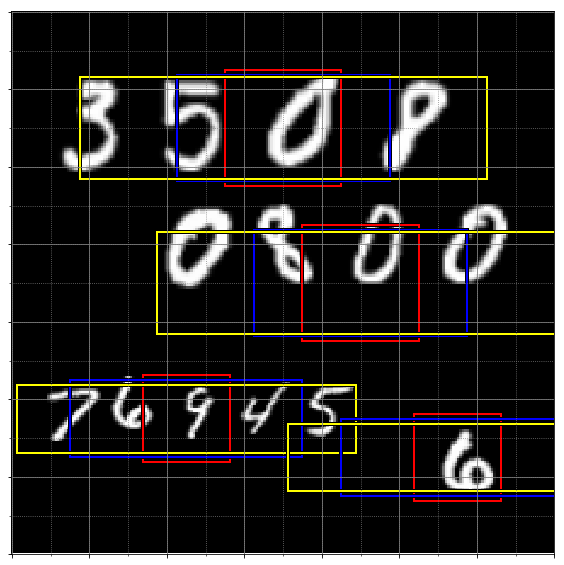

In [416]:
offset_fm2 = 14*14
plot_anchors(anchors.numpy(),
             make_sample(datasets_mnist['train'], (224, 224), min_seq=3, max_seq=6, seed=42)[0],
             #ixs=[66, 218, 226, 165])
             ixs=[
                 10*14+4, #76945
                 11*14+11, #6
                 offset_fm2+10, #3508
                 offset_fm2+25, #0800
            ])

## Definindo modelo

In [314]:
# Cálculo do bias das camadas convolutivas de classificação
# pi: probabilidade prior para predição de objeto
pi = 0.01; np.log((1-pi)/pi)

4.59511985013459

In [341]:
def make_conv_block(in_channels, out_channels, kernel_size=3, padding=1, p=None):
    layers = [
        nn.Conv2d(in_channels=in_channels,
                  out_channels=out_channels,
                  kernel_size=kernel_size,
                  padding=padding,
                  bias=False,
                 ),
        nn.LeakyReLU(),
        nn.BatchNorm2d(out_channels),
    ]
    if p is not None and p > 0:
        layers.append(nn.Dropout2d(p))

    return nn.Sequential(*layers)


def flatten_conv(x, k):
    """Converts a feature map to shape (batch_size, box_features, N_boxes).
    k is the number of anchor boxes per feature map cell.
    e.g. if used for bbox offsets, output would be (batch_size, 4, N_boxes).
    For class scores, output would be (batch_size, num_classes, N_boxes). """
    nb, nf, gx, gy = x.size()
    x = x.permute(0, 2, 3, 1).contiguous()
    return x.view(nb, -1, nf//k)


class OutConv(nn.Module):
    
    def __init__(self, in_channels, num_classes, k=1):
        super().__init__()
        self.k = k
        self.out_conv1 = nn.Sequential(
            make_conv_block(in_channels, in_channels, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=in_channels, out_channels=4*k, kernel_size=3, padding=1),
        )
        self.out_conv2 = nn.Conv2d(in_channels=in_channels, out_channels=(num_classes)*k, kernel_size=3,
                                   padding=1)
        
        # Initializes out_conv2 bias according to Focal Loss paper (section 4.1)
        # using pi=0.01 => bias = -log((1-pi)/pi) = -4.5
        # if pi=0.05 => bias = -3
        self.out_conv2.bias.data.fill_(-4.5)
        
    def forward(self, x):
        # Returns a list with bboxes coordinates offsets and predicted class scores
        return [flatten_conv(self.out_conv1(x), k=self.k),
                flatten_conv(self.out_conv2(x), k=self.k)]


class MyModel(nn.Module):

    def __init__(self, num_classes, k):
        super(MyModel, self).__init__()
        
        self.num_classes = num_classes
        self.k = k
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        p = None
        
        # Contracting branch: max pooling every 2 convs
        self.conv1 = make_conv_block(in_channels=1, out_channels=10, kernel_size=3, p=p)
#         self.conv2 = make_conv_block(in_channels=10, out_channels=10, kernel_size=1, padding=0, p=p)
        self.conv2 = make_conv_block(in_channels=10, out_channels=10, kernel_size=3, p=p)
        
        self.conv3 = make_conv_block(in_channels=10, out_channels=15, kernel_size=3, p=p)
        # self.conv4 = make_conv_block(in_channels=20, out_channels=20, kernel_size=1, padding=0, p=p)
        self.conv4 = make_conv_block(in_channels=15, out_channels=15, kernel_size=3, padding=1, p=p)
        
        self.conv5 = make_conv_block(in_channels=15, out_channels=20, kernel_size=3, p=p)
        # self.conv6 = make_conv_block(in_channels=40, out_channels=40, kernel_size=1, padding=0, p=p)
        self.conv6 = make_conv_block(in_channels=20, out_channels=20, kernel_size=3, padding=1, p=p)
        
        self.conv7 = make_conv_block(in_channels=20, out_channels=25, kernel_size=3, p=p)
        # self.conv8 = make_conv_block(in_channels=80, out_channels=80, kernel_size=1, padding=0, p=p)
        self.conv8 = make_conv_block(in_channels=25, out_channels=25, kernel_size=3, padding=1, p=p)
        
        self.conv9 = make_conv_block(in_channels=25, out_channels=30, kernel_size=3, p=p)
        # self.conv10 = make_conv_block(in_channels=160, out_channels=160, kernel_size=1, padding=0, p=p)
        self.conv10 = make_conv_block(in_channels=30, out_channels=30, kernel_size=3, padding=1, p=p)
        
        self.conv11 = make_conv_block(in_channels=30, out_channels=30, kernel_size=3, p=p)
        # self.conv12 = make_conv_block(in_channels=320, out_channels=320, kernel_size=1, padding=0, p=p)
        self.conv12 = make_conv_block(in_channels=30, out_channels=30, kernel_size=3, padding=1, p=p)
        
        self.conv13 = make_conv_block(in_channels=60, out_channels=30, kernel_size=1, padding=0)
        
        # Prediction layers
        # out_channels= (4 + (num_classes+1)) * k:
        # For each anchor:
        #    2 channels for object and non-object probability scores)
        #    2 channels for box center x and y offsets
        #    10 channels for prob scores of the 10 classes
        self.out_conv1 = OutConv(in_channels=30, num_classes=num_classes, k=k)
        self.out_conv2 = OutConv(in_channels=30, num_classes=num_classes, k=k)
        
        # Construct Anchors and register as buffers
        anchors = torch.cat((
            torch.cat((
                make_anchors(14, (36/224, 36/224)),
                make_anchors(14, (3*32/224, 32/224)),
                make_anchors(14, (5*28/224, 28/224)),
            ), dim=1).view(-1, 4).contiguous(),

            torch.cat((
                make_anchors(7, (48/224, 48/224)),
                make_anchors(7, (2*44/224, 44/224)),
                make_anchors(7, (4*42/224, 42/224)),
            ), dim=1).view(-1, 4).contiguous()
        ), dim=0)

        anchors_cnr = hw2corners(anchors[:, :2], anchors[:, 2:])
        
        grid_sizes = torch.cat((
            torch.tensor([1/14]).repeat((14*14 * k, 1)),
            torch.tensor([1/7]).repeat((7*7 * k, 1))
        ), dim=0)

        
        
        self.register_buffer('anchors', anchors)
        self.register_buffer('anchors_cnr', anchors_cnr)
        self.register_buffer('grid_sizes', grid_sizes)
  
        
    def forward(self, x):
        
        # print(x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        # print(x.shape)
        x = self.max_pool(x)
        # print(x.shape)
        x = self.conv3(x)
        x = self.conv4(x)
        #print(x.shape)
        x = self.max_pool(x)
        #print(x.shape)
        x = self.conv5(x)
        x = self.conv6(x)
        #print(x.shape)
        x = self.max_pool(x)
        #print(x.shape)
        x = self.conv7(x)
        x = self.conv8(x)
        # print(x.shape)
        x = self.max_pool(x)
        #print(x.shape)
        x = self.conv9(x)
        #print(x.shape)
        fm1 = self.conv10(x)
        #print('fm1:',fm1.shape)
        x = self.max_pool(fm1)
        #print(x.shape)
        x = self.conv11(x)
        x = self.conv12(x)
        #print(x.shape)
        
        up1 = F.interpolate(x, fm1.shape[-2:], mode='bilinear', align_corners=False)
        piramid1 = torch.cat([up1, fm1], dim=1)
        piramid1 = self.conv13(piramid1)

        y1 = self.out_conv1(piramid1)
        # print(y1.shape)
        y2 = self.out_conv2(x)
        # print(y2.shape)
        
        # output: boxes coordinates offsets and boxes class scores
        return [torch.cat([y1[0], y2[0]], dim=1),
                torch.cat([y1[1], y2[1]], dim=1)]

### Visualizando o funcionamento de `flatten_conv`

`a` é um feature map de dimensões `(1, 12, 2, 2)`, isto é, dimensões `(2,2)` com `12` canais (simulando as coordenadas para `k=3` anchors por célula do grid.

In [313]:
fm = torch.zeros(1, 4*3, 2, 2)
for i in range(2):
    for j in range(2):
        fm[0, :, i, j] = torch.arange(1,13) + (i*2) + j
print('Canais da célula (i,j):')
print('(0,0):', fm[0, :, 0, 0])
print('(0,1):', fm[0, :, 0, 1])
print('(1,0):', fm[0, :, 1, 0])
print('(1,1):', fm[0, :, 1, 1])

Canais da célula (i,j):
(0,0): tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])
(0,1): tensor([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.])
(1,0): tensor([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.])
(1,1): tensor([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.])


In [259]:
flatten_conv(fm, k=3)

tensor([[[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.],
         [ 2.,  3.,  4.,  5.],
         [ 6.,  7.,  8.,  9.],
         [10., 11., 12., 13.],
         [ 3.,  4.,  5.,  6.],
         [ 7.,  8.,  9., 10.],
         [11., 12., 13., 14.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]]])

### Instanciando modelo para `k=3` e apenas 1 classe (presença de objeto)

In [342]:
num_classes = 1
k = 3
model = MyModel(num_classes=num_classes, k=k)

In [343]:
model

MyModel(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(15,

### Testando o shape de saída

In [345]:
x = torch.randn((10, 1, 224, 224))
with torch.no_grad():
    y1, y2 = model(x)
print('Boxes coordinates:', y1.shape)
print('Boxes class scores:', y2.shape)

Boxes coordinates: torch.Size([10, 735, 4])
Boxes class scores: torch.Size([10, 735, 1])


In [347]:
print(model.anchors[:5*k])
print(model.anchors[-5*k:])

tensor([[0.0357, 0.0357, 0.1607, 0.1607],
        [0.0357, 0.0357, 0.4286, 0.1429],
        [0.0357, 0.0357, 0.6250, 0.1250],
        [0.1071, 0.0357, 0.1607, 0.1607],
        [0.1071, 0.0357, 0.4286, 0.1429],
        [0.1071, 0.0357, 0.6250, 0.1250],
        [0.1786, 0.0357, 0.1607, 0.1607],
        [0.1786, 0.0357, 0.4286, 0.1429],
        [0.1786, 0.0357, 0.6250, 0.1250],
        [0.2500, 0.0357, 0.1607, 0.1607],
        [0.2500, 0.0357, 0.4286, 0.1429],
        [0.2500, 0.0357, 0.6250, 0.1250],
        [0.3214, 0.0357, 0.1607, 0.1607],
        [0.3214, 0.0357, 0.4286, 0.1429],
        [0.3214, 0.0357, 0.6250, 0.1250]])
tensor([[0.3571, 0.9286, 0.2143, 0.2143],
        [0.3571, 0.9286, 0.3929, 0.1964],
        [0.3571, 0.9286, 0.7500, 0.1875],
        [0.5000, 0.9286, 0.2143, 0.2143],
        [0.5000, 0.9286, 0.3929, 0.1964],
        [0.5000, 0.9286, 0.7500, 0.1875],
        [0.6429, 0.9286, 0.2143, 0.2143],
        [0.6429, 0.9286, 0.3929, 0.1964],
        [0.6429, 0.9286, 0.7500, 

# Datasets e DataLoaders

In [348]:
ds = {
    'train': MultiSequenceDataset(datasets_mnist['train'],
                                  length=2048, #16384,
                                  image_size=(224, 224),
                                  transform=torchvision.transforms.ToTensor(),
                                  random=False),
    'val': MultiSequenceDataset(datasets_mnist['val'],
                                length=512, #4096,
                                image_size=(224, 224),
                                transform=torchvision.transforms.ToTensor(),
                                random=False),
}

def collate_fn(batch):
    """Separates a list of (img, dict('coords', 'label')) into a batch."""
    imgs = torch.stack(tuple(d[0] for d in batch), dim=0)
    coords = [
        torch.from_numpy(np.stack([box['coords'] for box in sample[1]], axis=0)).float() for sample in batch
    ]
    # Override labels to output always 0 (presence of digits)
    # labels = [torch.tensor([box['label'] for box in sample[1]]) for sample in batch]
    labels = [torch.tensor([0 for box in sample[1]]) for sample in batch]
    return imgs, (coords, labels)

In [349]:
bs = 64
dls = {
    'train': data.DataLoader(ds['train'],
                             batch_size=bs,
                             num_workers=os.cpu_count(),  # put 0 here to debug
                             shuffle=True,
                             collate_fn=collate_fn),
    'val': data.DataLoader(ds['val'],
                           batch_size=bs,
                           num_workers=os.cpu_count(),
                           shuffle=False,
                           collate_fn=collate_fn),
}

## Visualizando shapes e dtypes

In [350]:
def get_batch(dl):
    n_workers = dl.num_workers
    dl.num_workers = 0
    X, Y = next(iter(dl))
    dl.num_workers = n_workers
    return X, Y

In [351]:
X, Y = get_batch(dls['train'])

print(X.shape, X.type(), X.min(), X.max())

print('Boxes:', len(Y[0]), len(Y[0][0]), len(Y[0][0][0]))
print(Y[0][0], Y[0][0].dtype)
print('Labels:', len(Y[1]), len(Y[1][0]))
print(Y[1][0], Y[1][0].dtype)

torch.Size([64, 1, 224, 224]) torch.FloatTensor tensor(0.) tensor(1.)
Boxes: 64 3 4
tensor([[0.1071, 0.5268, 0.7188, 0.7455],
        [0.3125, 0.3661, 0.8259, 0.5045],
        [0.4688, 0.0134, 0.7991, 0.1875]]) torch.float32
Labels: 64 3
tensor([0, 0, 0]) torch.int64


In [352]:
X, Y = get_batch(dls['val'])

print(X.shape, X.type(), X.min(), X.max())

print('Boxes:', len(Y[0]), len(Y[0][0]), len(Y[0][0][0]))
print(Y[0][0], Y[0][0].dtype)
print('Labels:', len(Y[1]), len(Y[1][0]))
print(Y[1][0], Y[1][0].dtype)

torch.Size([64, 1, 224, 224]) torch.FloatTensor tensor(0.) tensor(1.)
Boxes: 64 3 4
tensor([[0.4598, 0.0402, 0.6607, 0.2411],
        [0.3036, 0.2902, 0.7188, 0.5089],
        [0.1696, 0.5938, 0.9777, 0.8125]]) torch.float32
Labels: 64 3
tensor([0, 0, 0]) torch.int64


In [353]:
# model = model.cpu()
with torch.no_grad():
    for b_box, b_cls, box, cls in zip(*model(X), *Y):
        print(b_box.shape)
        print(b_cls.shape)
        print(box.shape)
        print(cls.shape)
        break

torch.Size([735, 4])
torch.Size([735, 1])
torch.Size([3, 4])
torch.Size([3])


In [354]:
# Conferindo probabilidades prior de objeto (~ pi definido no modelo)
b_cls.sigmoid()[:5]

tensor([[0.0106],
        [0.0095],
        [0.0147],
        [0.0113],
        [0.0117]])

In [355]:
b_cls.sigmoid().max()

tensor(0.0358)

# Loss customizada e Trainer

Funções transcritas do notebook pascal-multi do fast.ai.

In [356]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1).to(pred.device)
        ## t = V(t[:,:-1].contiguous())#.cpu()    # Linha do fast.ai. Abaixo está a equivalente
        t = t[:,:-1].contiguous().requires_grad_(False)
        # x = pred[:,:-1]    # Essa linha assume um modelo com num_classes+1 saídas e ignora a última saída
        x = pred   # Essa linha assume um modelo sem classe específica para backgroud (implícito)
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, reduction='sum')/self.num_classes
    
        # x = pred
        # t = t.contiguous().requires_grad_(False)
        # w = self.get_weight(pred, t)
        # pos_weight = torch.tensor([1.]*10 + [0.1], requires_grad=False).to(pred.device)
        # pos_weight = None
        # return F.binary_cross_entropy_with_logits(x, t, w, pos_weight=pos_weight)
    
    def get_weight(self,x,t):
        return None
    

class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha, gamma = 0.75, 2
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

# loss_f = BCE_Loss(num_classes)
loss_f = FocalLoss(num_classes)

## Funções para cálculo do IoU

In [357]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b):
    return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

### Testes de cálculo de IoU

Testando IoU entre boxes 28x28 (menor dígito) e 37x37

In [358]:
# IoU de feature map com anchor 37x37 e dígito 28x28
box_a = torch.tensor([[0., 0., 37., 37.]])
box_b = torch.tensor([[0., 0., 28., 28.]])
print(jaccard(box_a, box_b))

box_a = torch.tensor([[10., 10., 38., 38.]])
box_b = torch.tensor([[0., 0., 28., 28.]])
print(jaccard(box_a, box_b))

tensor([[0.5727]])
tensor([[0.2605]])


In [359]:
# IoU de feature map com anchor 37x37 e dígito 56x56
box_a = torch.tensor([[0., 0., 37., 37.]])
box_b = torch.tensor([[0., 0., 56., 56.]])
jaccard(box_a, box_b)

tensor([[0.4365]])

In [360]:
# IoU de feature map com anchor 46x46 e dígito 28x28
box_a = torch.tensor([[0., 0., 46., 46.]])
box_b = torch.tensor([[0., 0., 28., 28.]])
jaccard(box_a, box_b)

tensor([[0.3705]])

In [361]:
# IoU de feature map com anchor 46x46 e dígito 56x56
box_a = torch.tensor([[0., 0., 46., 46.]])
box_b = torch.tensor([[0., 0., 56., 56.]])
jaccard(box_a, box_b)

tensor([[0.6747]])

### Funções para treinamento

In [362]:
def actn_to_bb(actn, anchors):
    """
    Uses the predicted bounding box offsets parameters to modify 
    the anchors (shift the centers and scale the width and height).
    The regression offset to predicted bounding box equations are:
    p_cx = t_cx * a_w + a_cx
    p_cy = t_cy * a_h + a_cy
    p_w = a_w * exp(t_w)
    p_h = a_h * exp(t_h)
    Returns the final predicted boxes in the format (cx, cy, w, h).
    """
    # Desloca centros das anchors:
    pred_centers = (actn[:,:2] * anchors[:, 2:]) + anchors[:,:2]
    pred_wh = anchors[:,2:] * torch.exp(actn[:, 2:])
    return torch.cat([pred_centers, pred_wh], dim=1)


def build_bbox_targets(bbox_gt, anchors):
    """Build bbox regression targets from ground-truth boxes and anchors.
    The equations to produce the regression targets are:
    t_cx = (gt_cx - a_cx) / a_w
    t_cy = (gt_cy - a_cy) / a_h
    tw = log(gt_w / a_w)
    th = log(gt_h / a_h)
    """
    bbox_gt = corners2centerhw(bbox_gt[:, :2], bbox_gt[:, 2:])
    
    tx = (bbox_gt[:, :1] - anchors[:, :1]) / anchors[:, 2:3]
    ty = (bbox_gt[:, 1:2] - anchors[:, 1:2]) / anchors[:, 3:4]
    tw = torch.log(bbox_gt[:, 2:3]/anchors[:, 2:3])
    th = torch.log(bbox_gt[:, 3:4]/anchors[:, 3:4])
    
    return torch.cat([tx, ty, tw, th], dim=1)


def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
    # import pdb; pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx):
        gt_idx[o] = i
    return gt_overlap, gt_idx


def negative_mining(neg_idx, num_boxes):
    # Select `num_boxes` randomly from neg_idx boxes.
    select_idx = np.arange(len(neg_idx))
    np.random.shuffle(select_idx)
    select_idx = select_idx[:num_boxes]
    select_idx = torch.from_numpy(select_idx).long().to(neg_idx.device)
    neg_idx = neg_idx[select_idx]
    return neg_idx

def hard_negative_mining(neg_idx, neg_cls_scores, final_num):
    # Sorts negative boxes by background class score and picks
    # the boxes with lower scores (higher error)
    selected_idx = torch.sort(neg_cls_scores[:, -1])[1][:final_num]
    return neg_idx[selected_idx]

    
def ssd_1_loss(b_c, b_bb, bbox, clas, print_it=False):
    # bbox, clas = get_y(bbox, clas)
    # Obtem as boxes preditas pelo modelo
    # a_ic = actn_to_bb(b_bb, model.anchors)
    # Calcula o IoU entre os targets (bbox) e as âncoras
    overlaps = jaccard(bbox.data, model.anchors_cnr.data)
    # Realiza o match entre as ancoras e as boxes GT pelo IoU
    gt_overlap, gt_idx = map_to_ground_truth(overlaps, print_it)
    # Constrói os tensores target (gt_clas e gt_bbox)
    # gt_clas deve possuir um índice de classe para cada bbox predita
    # gt_bbox deve possuir 4 parâmetros para cada bbox predito
    # Associa as classes corretas para as boxes que foram match
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    # Seta classe background (classe 10) para anchors sem match
    gt_clas[1-pos] = num_classes
    # Constroi gt_bbox usando, para cada anchor, a bbox GT com maior overlap
    gt_bbox = bbox[gt_idx]
    # Localization loss: Smooth L1 Loss nos parâmetros de regressão tx, ty, tw, th
    # Considera apenas as boxes que foram match
    gt_bbox_reg_targets = build_bbox_targets(gt_bbox, model.anchors)
    loc_loss = F.smooth_l1_loss(b_bb[pos_idx], gt_bbox_reg_targets[pos_idx]) 
    # Class loss:
    # Hard negative mining
    # neg_idx = torch.nonzero(1-pos)[:,0]
    # import pdb; pdb.set_trace()
    # neg_idx = hard_negative_mining(neg_idx, b_c[neg_idx], 2*len(pos_idx))
    # select_idx = torch.cat([pos_idx, neg_idx])
    # clas_loss  = loss_f(b_c[select_idx], gt_clas[select_idx])
    # Normaliza o erro de classificação pelo número de exemplos positivos
    clas_loss  = loss_f(b_c, gt_clas) / len(pos_idx)
    
    return loc_loss, clas_loss

def ssd_loss(pred, targ, print_it=False):
    lcs, lls = 0., 0.
    # Itera nas imagens do batch
    for b_box, b_cls, bbox, clas in zip(*pred, *targ):
        loc_loss, clas_loss = ssd_1_loss(b_cls, b_box, bbox, clas, print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.item()}, clas: {lcs.item()}')
    return lls + lcs

### Visualizando o match de âncoras com boxes ground-truth usando IoU

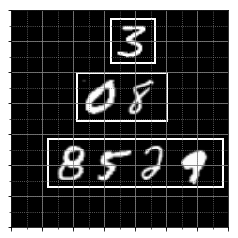

In [363]:
ax = show_img(X[0].cpu().numpy().squeeze(0))
boxes = Y[0][0]
boxes = corners2xyhw(boxes[:, :2], boxes[:, 2:])
for box in boxes:
    draw_rect(ax, box.cpu().numpy()*224)

In [364]:
classes = Y[1][0]
classes

tensor([0, 0, 0])

In [365]:
boxes = Y[0][0]
# boxes x0, y0, x1, y1
boxes

tensor([[0.4598, 0.0402, 0.6607, 0.2411],
        [0.3036, 0.2902, 0.7188, 0.5089],
        [0.1696, 0.5938, 0.9777, 0.8125]])

In [366]:
Y[1]

[tensor([0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0]),
 tensor([0, 0, 0, 0

In [367]:
targ = Y[0][0]
jaccard(targ, model.anchors_cnr).shape

torch.Size([3, 735])

In [368]:
# Cálculo do match de cada bbox GT (IoU + índice da anchor com maior IoU)
gt_iou, anc_ix = torch.max(jaccard(targ.data, model.anchors_cnr), dim=1)
gt_iou, anc_ix

(tensor([0.5332, 0.6294, 0.4695]), tensor([ 63, 640, 686]))

In [369]:
matched_ancs = model.anchors_cnr[anc_ix]; matched_ancs

tensor([[0.4554, 0.0268, 0.6161, 0.1875],
        [0.3036, 0.2589, 0.6964, 0.4554],
        [0.2679, 0.5491, 1.0179, 0.7366]])

### Visualizando os matches da primeira etapa de matching

1 anchor para cada box GT

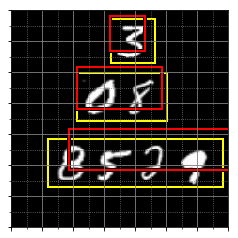

In [370]:
matched_ancs = model.anchors_cnr[anc_ix]; matched_ancs

ax = show_img(X[0].cpu().numpy().squeeze(0))
boxes = Y[0][0]
boxes = corners2xyhw(boxes[:, :2], boxes[:, 2:])
for box in boxes:
    draw_rect(ax, box.cpu().numpy()*224, color='yellow')

matched_ancs = corners2xyhw(matched_ancs[:, :2], matched_ancs[:, 2:])
for anc in matched_ancs[:]:
    draw_rect(ax, anc.cpu().numpy()*224, color='red')

In [371]:
# Cálculo dos matches secundários:
# Deve calcular o maior IoU entre cada anchor box e as boxes GT.
# Se alguma ultrapassar o limiar (e não tiver sido match na etapa acima),
# é match também (mais de uma anchor para uma mesma box GT)
torch.max(jaccard(targ, model.anchors_cnr), dim=0)

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0155,
         0.0000, 0.0030, 0.0530, 0.0000, 0.0527, 0.0932, 0.0156, 0.1076, 0.1091,
         0.1077, 0.1526, 0.1091, 0.2183, 0.1526, 0.1091, 0.1814, 0.1526, 0.1091,
         0.0772, 0.1487, 0.1091, 0.0000, 0.0898, 0.1091, 0.0000, 0.0366, 0.0803,
         0.0000, 0.0000, 0.0410, 0.0000, 0.0000, 0.0044, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0341, 0.0000, 0.0061, 0.1215,
         0.0000, 0.1153, 0.2250, 0.0307, 0.2511, 0.2689, 0.2327, 0.3768, 0.2689,
         0.5332, 0.3768, 0.2689, 0.4247, 0.3768, 0.2689, 0.1616, 0.3654, 0.2689,
         0.0000, 0.2052, 0.2689, 0.0000, 0.0787, 0.1907, 0.0000, 0.0000, 0.0926,
         0.0000, 0.0000, 0.0095, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0341, 0.0000, 0.0059, 0.1215, 0.0000, 0.1112, 0.2250,
         0.0298, 0.2411, 0.2689, 0.2241, 0.3603, 0.2689, 0.5089, 0.3603, 0.2689,
         0.4066, 0.3603, 0.2

In [372]:
# Função que realiza as 2 etapas acima.
# Os matches "primários" ficam com IoU de 1.99 para garantir match
gt_overlap, gt_idx = map_to_ground_truth(jaccard(targ.data, model.anchors_cnr), print_it=True)
gt_overlap, gt_idx

tensor([0.5332, 0.6294, 0.4695])


(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0155,
         0.0000, 0.0030, 0.0530, 0.0000, 0.0527, 0.0932, 0.0156, 0.1076, 0.1091,
         0.1077, 0.1526, 0.1091, 0.2183, 0.1526, 0.1091, 0.1814, 0.1526, 0.1091,
         0.0772, 0.1487, 0.1091, 0.0000, 0.0898, 0.1091, 0.0000, 0.0366, 0.0803,
         0.0000, 0.0000, 0.0410, 0.0000, 0.0000, 0.0044, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0341, 0.0000, 0.0061, 0.1215,
         0.0000, 0.1153, 0.2250, 0.0307, 0.2511, 0.2689, 0.2327, 0.3768, 0.2689,
         1.9900, 0.3768, 0.2689, 0.4247, 0.3768, 0.2689, 0.1616, 0.3654, 0.2689,
         0.0000, 0.2052, 0.2689, 0.0000, 0.0787, 0.1907, 0.0000, 0.0000, 0.0926,
         0.0000, 0.0000, 0.0095, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0341, 0.0000, 0.0059, 0.1215, 0.0000, 0.1112, 0.2250,
         0.0298, 0.2411, 0.2689, 0.2241, 0.3603, 0.2689, 0.5089, 0.3603, 0.2689,
         0.4066, 0.3603, 0.2

In [373]:
for i, (gt_ov, gt_ix) in enumerate(zip(gt_overlap, gt_idx)):
    if gt_ov > 0.5:
        is_primary_match = gt_ov == 1.99
        print(f'Anchor {i}: match com GT box {gt_ix.item()} | IoU {gt_ov.item():.4f}', end='')
        print(' (match primário)' if is_primary_match else '')

Anchor 63: match com GT box 0 | IoU 1.9900 (match primário)
Anchor 105: match com GT box 0 | IoU 0.5089
Anchor 229: match com GT box 1 | IoU 0.5440
Anchor 232: match com GT box 1 | IoU 0.5957
Anchor 640: match com GT box 1 | IoU 1.9900 (match primário)
Anchor 686: match com GT box 2 | IoU 1.9900 (match primário)


#### Visualizando resultado final dos matches (1ª e 2ª etapas de match)

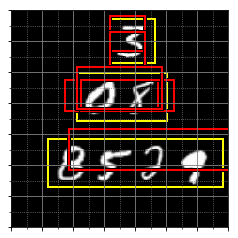

In [374]:
anc_ix = (gt_overlap > 0.5).nonzero()[:, 0]
matched_ancs = model.anchors_cnr[anc_ix]; matched_ancs

ax = show_img(X[0].cpu().numpy().squeeze(0))
boxes = Y[0][0]
boxes = corners2xyhw(boxes[:, :2], boxes[:, 2:])
for box in boxes:
    draw_rect(ax, box.cpu().numpy()*224, color='yellow')

matched_ancs = corners2xyhw(matched_ancs[:, :2], matched_ancs[:, 2:])
for anc in matched_ancs[:]:
    
    draw_rect(ax, anc.cpu().numpy()*224, color='red')

#### Cálculo da função de custo para 2 amostras

In [376]:
pred = model(X[:2])
ssd_loss((pred[0], pred[1]), (Y[0], Y[1]), print_it=True)

tensor([0.5332, 0.6294, 0.4695])
tensor([0.4850, 0.5405, 0.7646])
loc: 0.327008992433548, clas: 6.532975196838379


tensor(6.8600, grad_fn=<ThAddBackward>)

O erro de classe é muito superior ao de localização inicialmente, mas cai rapidamente por conta da Focal Loss.

## Treinamento

In [377]:
class IoUMetric(ptt.Callback):
    def __init__(self):
        super().__init__()
        self.name1 = 'iou_0.8'
        self.name2 = 'iou_0.5'
        self.name3 = 'iou_0.2'

    def on_batch_end(self, epoch_num, batch_num, x, y_true, y_pred, loss):
        pass

    def on_vbatch_end(self, epoch_num, batch_num, x, y_true, y_pred, loss):
        batch_box, batch_cls = y_pred
        #import pdb; pdb.set_trace()
        recall = 0
        for box, cls, gt_box, gt_cls in zip(batch_box, batch_cls, y_true[0], y_true[1]):
            box = actn_to_bb(box, self.trainer.model.anchors)
            # idx_obj: foregound boxes
            cls_prob, cls_pred = cls.sigmoid().max(1)
            idx_obj = (cls_prob > 0.5).nonzero()
            if len(idx_obj):
                idx_obj = idx_obj[:, 0]
                box = box[idx_obj]
                box = hw2corners(box[:, :2], box[:, 2:])
                iou = jaccard(box, gt_box)   # out: (n_obj_boxes, n_gt)
                iou_max = iou.max(0)[0]
                self.valid_accum_1 += (iou_max > 0.8).sum().item()
                self.valid_accum_2 += (iou_max > 0.5).sum().item()
                self.valid_accum_3 += (iou_max > 0.2).sum().item()
            self.n_valid_samples += len(gt_box)

    def on_epoch_begin(self, epoch_num, metrics):
        self.valid_accum_1 = 0
        self.valid_accum_2 = 0
        self.valid_accum_3 = 0
        self.n_valid_samples = 0

    def on_epoch_end(self, epoch_num, metrics):
        if self.n_valid_samples > 0:
            metrics['valid'][self.name1].append(1.0 * self.valid_accum_1 / self.n_valid_samples)
            metrics['valid'][self.name2].append(1.0 * self.valid_accum_2 / self.n_valid_samples)
            metrics['valid'][self.name3].append(1.0 * self.valid_accum_3 / self.n_valid_samples)

    def on_train_begin(self, n_epochs, metrics):
        if self.name1 not in metrics['valid']:
            metrics['valid'][self.name1] = []
        if self.name2 not in metrics['valid']:
            metrics['valid'][self.name2] = []
        if self.name3 not in metrics['valid']:
            metrics['valid'][self.name3] = []

### Trainer

In [378]:
class MyTrainer(ptt.DeepNetTrainer):
    
    # init alterado para criar o optimizer após o método .to() no modelo
    def __init__(self, model, lr, devname='cpu', callbacks=[], **kwargs):
        self.dev_name = devname
        device = torch.device(self.dev_name)
        self.last_epoch = 0
        
        assert (model is not None)
        self.model = model.to(device)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-5)
        self.criterion = ssd_loss
        
        def lr_schedule(epoch):
            if epoch < 10:
                return 0.1
            elif 10 <= epoch < 50:
                return 1
            elif 50 <= epoch < 80:
                return 0.1
            elif 80 <= epoch < 110:
                return 0.01
            else:
                return 0.001
        
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_schedule)
        # SGDR: Scheduler that must be used as a callback
#         self.scheduler = None
#         To = kwargs.get('To', 1)
#         Tmul = kwargs.get('Tmul', 2)
#         sgdr = ptt.SGDRestarts(self.optimizer,
#                                self.last_epoch if self.last_epoch != 0 else -1,
#                                eta_min=1e-8,
#                                To=To,
#                                Tmul=Tmul,
#                                verbose=False)
#         callbacks.append(sgdr)
        
        self.metrics = dict(train=OrderedDict(losses=[]), valid=OrderedDict(losses=[]))
        
        self.callbacks = []
        if callbacks is not None:
            for cb in callbacks:
                self.callbacks.append(cb)
                cb.trainer = self

In [317]:
model = MyModel(num_classes, k=k)

In [389]:
model_basename = '.models/ssd_seq_focal_piramid_alpha0.75'
cb_chkpt = ptt.ModelCheckpoint(model_basename, reset=True, verbose=1, load_best=False)

trainer = MyTrainer(model,
                    lr=5e-4,
                    devname=0,
                    callbacks = [
                        IoUMetric(),
                        ptt.PrintCallback(),
                        cb_chkpt,
                    ],
                    To=5,
                    Tmul=2,
                   )

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f091db1df28>>
Traceback (most recent call last):
  File "/home/fabiocapsouza/anaconda3/envs/pytorch0.4/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/fabiocapsouza/anaconda3/envs/pytorch0.4/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/fabiocapsouza/anaconda3/envs/pytorch0.4/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/fabiocapsouza/anaconda3/envs/pytorch0.4/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/fabiocapsouza/anaconda3/envs/pytorch0.4/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connec

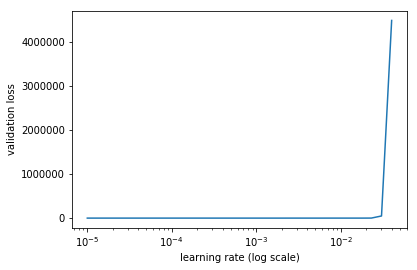

In [386]:
lrs, losses = trainer.lr_find(dls['train'], min_lr=1e-5, num_it=50)

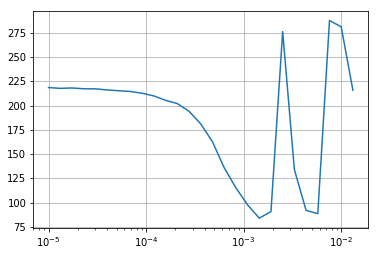

In [388]:
ix = -4
plt.plot(lrs[:ix], losses[:ix])
plt.xscale('log')
plt.grid(True)

In [390]:
n_epochs = 150
trainer.fit_loader(n_epochs, dls['train'], dls['val'])

Start training for 150 epochs
  1 (LRs: 5.00e-05):  12.7s   T: 3.22950 *   V: 3.44355 *  0.00000 *  0.00000 *  0.00000 *  
  2 (LRs: 5.00e-05):  12.6s   T: 2.82654 *   V: 2.86292 *  0.00000    0.00000    0.00000    
  3 (LRs: 5.00e-05):  12.9s   T: 2.42954 *   V: 2.08809 *  0.00000    0.01769    0.04533    
  4 (LRs: 5.00e-05):  12.9s   T: 2.07819 *   V: 1.75968 *  0.00166    0.08292    0.13820    
  5 (LRs: 5.00e-05):  13.0s   T: 1.77561 *   V: 1.54087 *  0.00608    0.16363    0.21061    
  6 (LRs: 5.00e-05):  12.9s   T: 1.51101 *   V: 1.31616 *  0.02819    0.28303    0.31620    
  7 (LRs: 5.00e-05):  13.1s   T: 1.28460 *   V: 1.14061 *  0.06468    0.37756    0.41183    
  8 (LRs: 5.00e-05):  13.1s   T: 1.09654 *   V: 0.97334 *  0.10669    0.48425    0.51962    
  9 (LRs: 5.00e-05):  13.0s   T: 0.94040 *   V: 0.85282 *  0.15091    0.56606    0.59923    
 10 (LRs: 5.00e-05):  13.2s   T: 0.81000 *   V: 0.74368 *  0.19071    0.62963    0.65616    
 11 (LRs: 5.00e-04):  13.1s   T: 0.41411

Process Process-520:
Process Process-518:
Process Process-519:
Traceback (most recent call last):
Process Process-517:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabiocapsouza/anaconda3/envs/pytorch0.4/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/fabiocapsouza/anaconda3/envs/pytorch0.4/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/fabiocapsouza/anaconda3/envs/pytorch0.4/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/fabiocapsouza/anaconda3/envs/pytorch0.4/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/fabiocapsouza/anaconda3/envs/pytorch0.4/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
Traceback (most rec

Stop training at epoch: 63/150
Best model was saved at epoch 52 with loss 0.04894: .models/ssd_seq_focal_piramid_alpha0.75


KeyboardInterrupt
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f091420d710>>
Traceback (most recent call last):
  File "/home/fabiocapsouza/anaconda3/envs/pytorch0.4/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/fabiocapsouza/anaconda3/envs/pytorch0.4/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 390, in _shutdown_workers
    self.worker_result_queue.put(None)
  File "/home/fabiocapsouza/anaconda3/envs/pytorch0.4/lib/python3.6/multiprocessing/queues.py", line 346, in put
    with self._wlock:
  File "/home/fabiocapsouza/anaconda3/envs/pytorch0.4/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/fabiocapsouza/anaconda3/envs/pytorch0.4/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 227, in handler
    _error_if_any_worker_fails(

In [391]:
trainer.load_state(model_basename)

## Visualizando resultados

In [392]:
def to_device(T, device):
    if isinstance(T, (list, tuple)):
        return [to_device(t, device) for t in T]
    elif isinstance(T, dict):
        return {k: to_device(t) for k, t in T.items()}
    return T.to(device)

def to_cpu(T):
    if isinstance(T, (list, tuple)):
        return tuple(t.cpu() for t in T)
    elif isinstance(T, dict):
        return {k: t.cpu() for k, t in T.items()}
    return T.cpu()

def to_np(T):
    T = to_cpu(T)
    if isinstance(T, (list, tuple)):
        return tuple(t.detach().numpy() for t in T)
    elif isinstance(T, dict):
        return {k: t.detach().numpy() for k, t in T.items()}
    return T.detach().numpy()

In [394]:
N = 40
X, Y = get_batch(dls['val'])
X = X[:N]
Y = (Y[0][:N], Y[1][:N])
X = to_device(X, 'cuda')
Y = to_device(Y, 'cuda')

with torch.no_grad():
    model = model.eval()
    pred = model(X)
ssd_loss(pred, Y)
bbox_pred = [
    torch.clamp(actn_to_bb(bb_pred, model.anchors), min=0, max=1) for bb_pred in pred[0]
]
bbox_pred = [hw2corners(bbox[:, :2], bbox[:, 2:]) for bbox in bbox_pred]
cls_prob, cls_pred = pred[1].max(2)   # max on (batch_size, boxes, cls_scores)
cls_prob = cls_prob.sigmoid()

pred = to_device(pred, 'cpu')
bbox_pred = to_device(bbox_pred, 'cpu')
cls_prob = to_device(cls_prob, 'cpu')
cls_pred = to_device(cls_pred, 'cpu')

In [395]:
# Malisiewicz et al.
# Adaptado de: https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def non_max_suppression_fast(boxes, confs, overlapThresh):
    
    if torch.is_tensor(boxes):
        boxes = to_np(boxes)
    if torch.is_tensor(confs):
        confs = to_np(confs)
    
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the highest confidences
    # area = (x2 - x1 + 1) * (y2 - y1 + 1)
    area = (x2 - x1) * (y2 - y1)
    idxs = np.argsort(confs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1)# + 1)
        h = np.maximum(0, yy2 - yy1)# + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # Return only the indices of the boxes that survived
    pick = np.asarray(pick, dtype=np.int)
    return pick


def show_sample(x, boxes, classes, probs=None, thresh=0.5, ax=None, nms=True, iou_thresh=0.5):
    ax = show_img(x, ax=ax)
    
    if probs is not None:
        idx = (probs > thresh).nonzero()
        idx = idx[:, 0] if len(idx) else torch.tensor([], dtype=torch.long)
        
        boxes, classes, probs = boxes[idx], classes[idx], probs[idx]
        if nms:
            nms_ix = non_max_suppression_fast(boxes, probs, overlapThresh=iou_thresh)
            boxes, classes, probs = boxes[nms_ix], classes[nms_ix], probs[nms_ix]

    for i, (b, c) in enumerate(zip(boxes, classes)):
        color = colr_list[i%12]
        box = torch.cat([b[:2], b[2:]-b[:2]]) * x.shape[-1]
        draw_rect(ax, box, color=color)
        draw_text(ax, box[:2], c.item(), color=color)

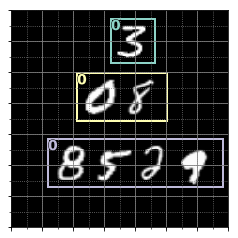

In [396]:
ix = 0
show_sample(X[ix].cpu().numpy().squeeze(), Y[0][ix], Y[1][ix])

In [397]:
#idx_obj = (cls_pred[ix] != 10).nonzero()[:, 0]
idx_obj = (cls_prob[ix] > 0.5).nonzero()

if len(idx_obj):
    idx_obj = idx_obj[:, 0]

boxes = bbox_pred[ix][idx_obj]
clss = cls_pred[ix][idx_obj]
probs = cls_prob[ix][idx_obj]

In [398]:
boxes.shape, clss.shape, probs.shape

(torch.Size([28, 4]), torch.Size([28]), torch.Size([28]))

In [399]:
boxes = bbox_pred[ix]
clss = cls_pred[ix]
probs = cls_prob[ix]

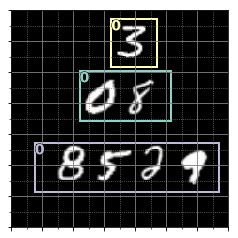

In [403]:
show_sample(X[ix].cpu().numpy().squeeze(), boxes, clss, probs=probs, thresh=0.5, iou_thresh=0.5)

In [404]:
nms_ix = non_max_suppression_fast(boxes, probs, overlapThresh=0.5)
nms_ix = torch.tensor(nms_ix)
nms_ix

tensor([640,  63, 686, 148, 101,  25, 720, 647, 143,  73, 555, 723, 579, 635,
        312, 651, 725, 585,  56,  32, 303, 605,  48, 732, 588, 507, 609, 306,
          6, 731, 375, 123, 546, 549, 693, 120, 590, 300, 548, 611, 316, 459,
        715, 124, 296, 291, 333, 506, 716, 672, 626, 712, 669, 338, 293, 421,
        653, 380, 327, 330, 673, 668, 335, 695, 376])

In [405]:
boxes, probs

(tensor([[-0.0569, -0.0492,  0.0983,  0.0885],
         [-0.2000, -0.0332,  0.2267,  0.0836],
         [-0.3137, -0.0047,  0.3137,  0.0830],
         ...,
         [ 0.8271,  0.8342,  1.0439,  0.9845],
         [ 0.8293,  0.8714,  1.1707,  1.0294],
         [ 0.4729,  0.8525,  1.3172,  1.0203]]),
 tensor([0.0112, 0.0051, 0.0061, 0.0101, 0.0037, 0.0037, 0.0108, 0.0045, 0.0040,
         0.0112, 0.0057, 0.0055, 0.0111, 0.0057, 0.0067, 0.0117, 0.0063, 0.0057,
         0.0321, 0.0170, 0.0047, 0.1499, 0.0282, 0.0043, 0.0962, 0.0412, 0.0039,
         0.0081, 0.0251, 0.0086, 0.0053, 0.0092, 0.0140, 0.0076, 0.0067, 0.0086,
         0.0081, 0.0055, 0.0071, 0.0112, 0.0069, 0.0065, 0.0086, 0.0040, 0.0035,
         0.0113, 0.0026, 0.0028, 0.0123, 0.0038, 0.0040, 0.0105, 0.0057, 0.0067,
         0.0082, 0.0080, 0.0141, 0.0075, 0.0212, 0.0198, 0.0954, 0.2197, 0.0127,
         0.9815, 0.3935, 0.0122, 0.9162, 0.4254, 0.0196, 0.0167, 0.1605, 0.0323,
         0.0056, 0.0207, 0.0284, 0.0054, 0.0071, 0.008

In [406]:
boxes[nms_ix], boxes[nms_ix].shape

(tensor([[ 0.3154,  0.2803,  0.7380,  0.5120],
         [ 0.4614,  0.0412,  0.6722,  0.2594],
         [ 0.1091,  0.6122,  0.9561,  0.8358],
         [ 0.4110,  0.1252,  0.7114,  0.3577],
         [ 0.2757,  0.0892,  0.6125,  0.2661],
         [ 0.4218, -0.0090,  0.7212,  0.1398],
         [ 0.2569,  0.8311,  0.4603,  1.0068],
         [ 0.4484,  0.2052,  1.1678,  0.4725],
         [ 0.1480,  0.1513,  0.6074,  0.3211],
         [ 0.4962,  0.0483,  0.8642,  0.2050],
         [ 0.1900,  0.9072,  0.3041,  1.0701],
         [ 0.4004,  0.8405,  0.5832,  1.0114],
         [ 0.7490,  0.8876,  0.8787,  1.0563],
         [-0.1632,  0.2941,  0.8368,  0.4984],
         [ 0.4001,  0.4422,  0.5632,  0.5930],
         [-0.0289,  0.3714,  0.1537,  0.6310],
         [ 0.1460,  0.8384,  0.8180,  1.0190],
         [ 0.8755,  0.8976,  1.0196,  1.0648],
         [ 0.1813,  0.0194,  0.7683,  0.2086],
         [ 0.4660, -0.0278,  0.9452,  0.1081],
         [ 0.2283,  0.4765,  0.3157,  0.6265],
         [ 0.

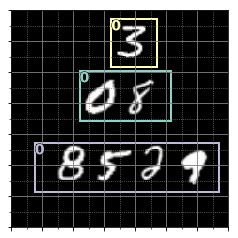

In [407]:
show_sample(X[ix].cpu().numpy().squeeze(), boxes[nms_ix], clss[nms_ix], probs=probs[nms_ix], thresh=0.5)

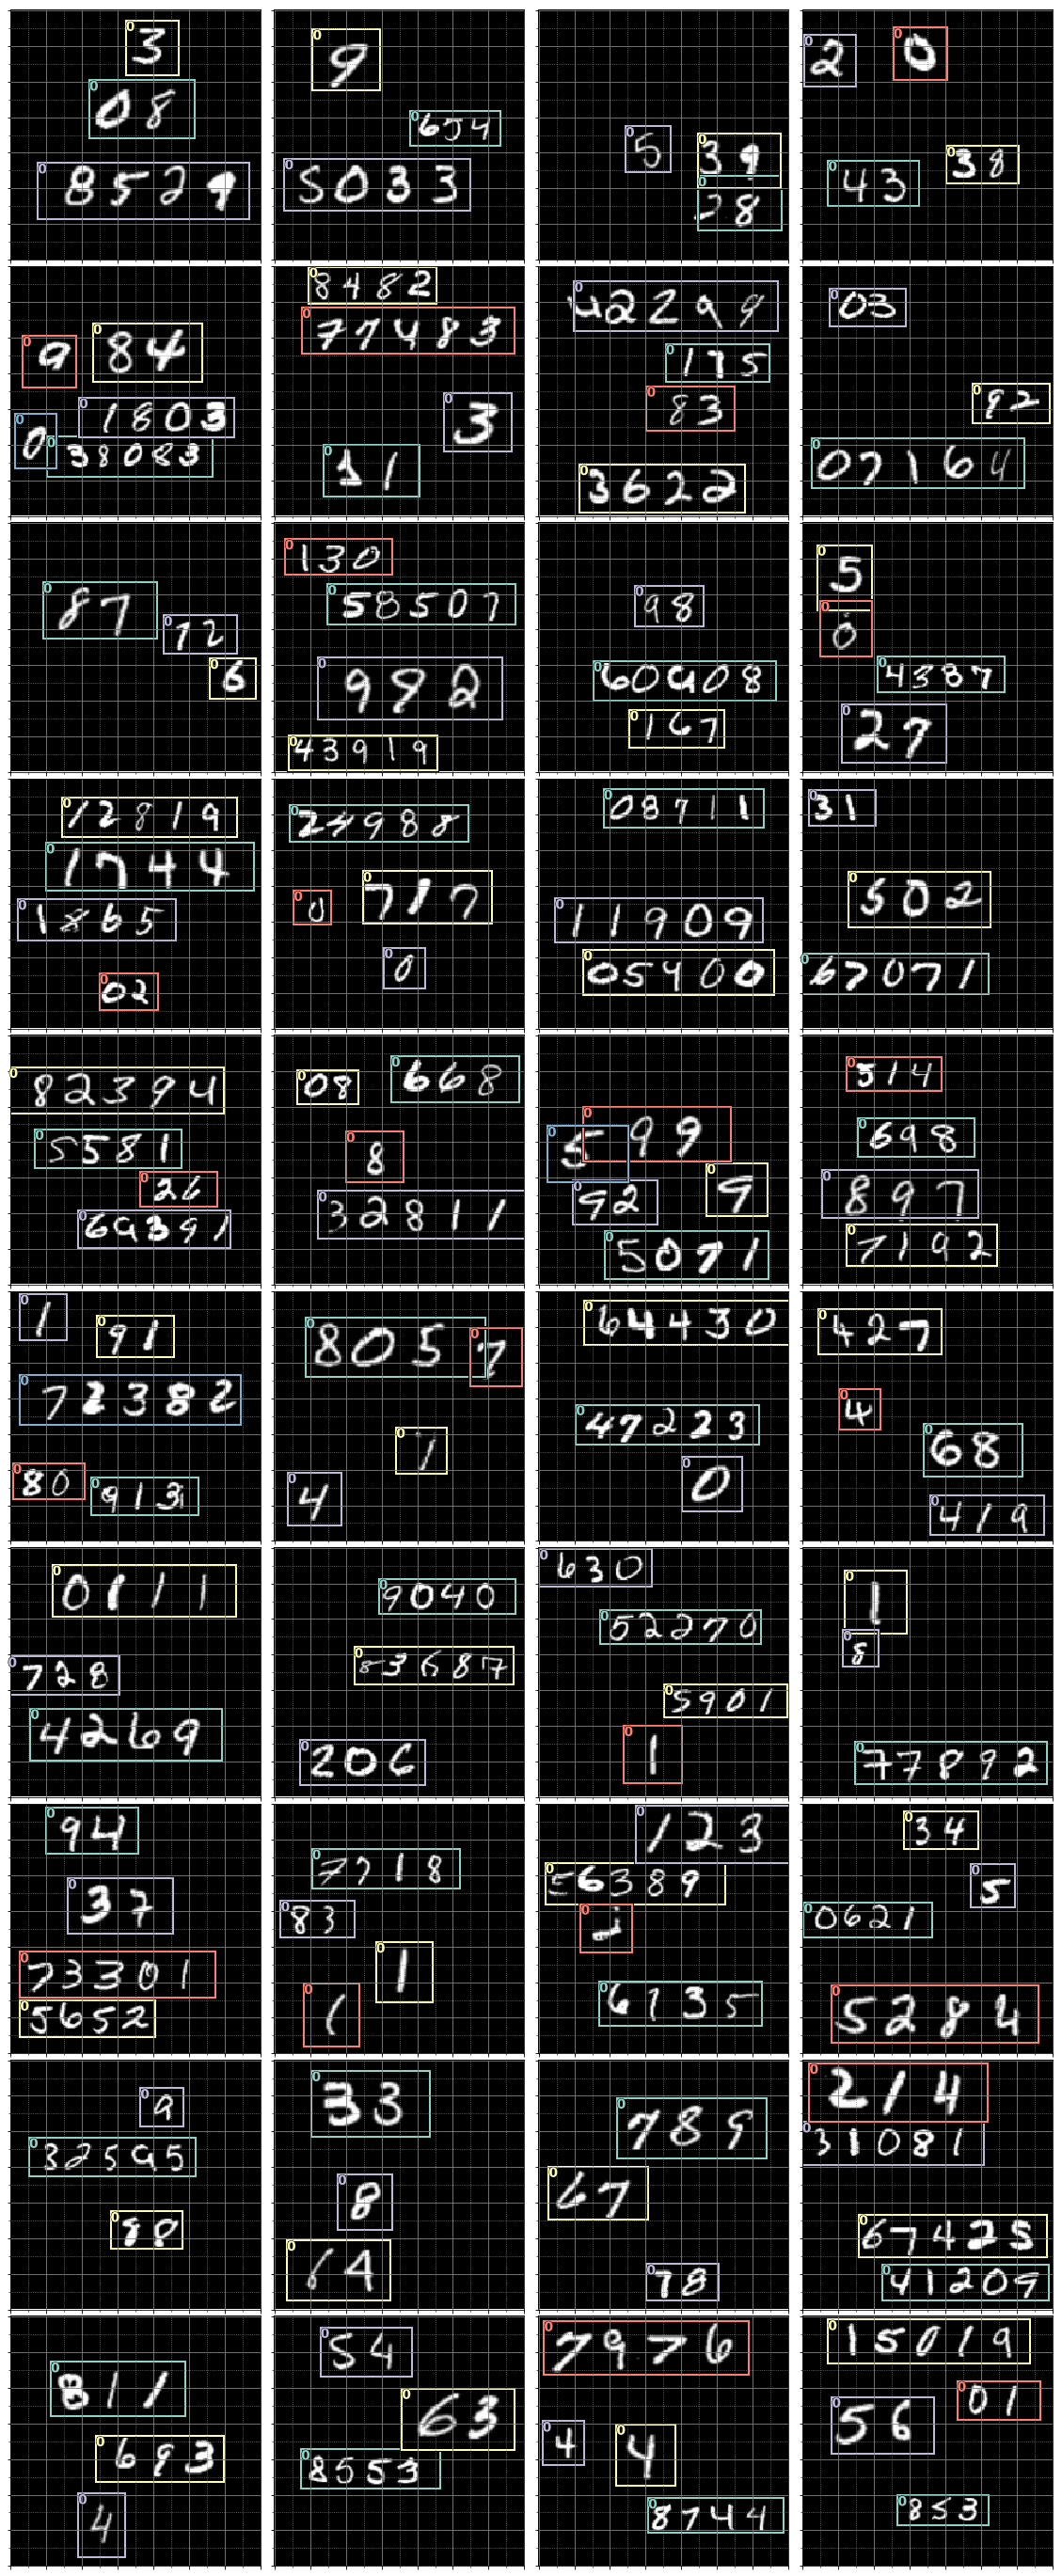

In [417]:
nrows, ncols = 10, 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
fig.subplots_adjust(hspace=0.025, wspace=0.025)
axs = np.ravel(axs)

thresh = 0.5
nms_iou_thresh = 0.5
for j, (x, boxes, clss, probs) in enumerate(zip(X, bbox_pred, cls_pred, cls_prob)):
    ax = axs[j]
    show_sample(to_np(x).squeeze(), boxes, clss, probs, ax=ax, thresh=thresh, nms=True, iou_thresh=nms_iou_thresh)